In [2]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
%matplotlib inline

import glob
import os
import random


In [3]:
# Making use of the raw dataset
df = pd.DataFrame()

# Labelling the data by gender 
male = [0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 13, 14, 17, 21, 23, 24, 27, 28, 29, 30, 33, 36, 37, 41, 42, 43, 44, 46, 48, 50, 51, 53, 56, 58, 59, 60, 61]
female = [4, 5, 8, 15, 16, 18, 19, 20, 22, 25, 26, 31, 32, 34, 35, 38, 39, 40, 45, 47, 49, 52, 54, 55, 57, 62]

# Importing the data and labelling by gender
for csv in glob.glob('./raw_subset/*.csv'):
    id = os.path.splitext(os.path.basename(csv))[0]
    new = pd.DataFrame(pd.read_csv(csv, header=None, skiprows=[0])).iloc[:, :-2]
    new['id'] = id
    new['gender'] = 'm' if int(id) + 1 in male else 'f'
    df = pd.concat([df, new])

# Extracting the column headings
columns = list(pd.read_csv('./raw_subset/1.csv', header=0).columns[:-2]) + ['id', 'gender']
print(df.columns, columns)
df.columns = columns
df.set_index(['id', 'index'], inplace=True)


Index([       0,        1,        2,        3,        4,        5,        6,
              7,        8,        9,       10,       11,       12,       13,
             14,       15,       16,       17,       18,       19,       20,
             21,       22,       23,       24,       25,       26,       27,
             28,       29,       30,       31,       32,       33,       34,
             35,       36,       37,       38,       39,       40,       41,
           'id', 'gender'],
      dtype='object') ['index', 'time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z', 'F_x', 'F_y', 'F_z', 'confidence', 'gaze_norm_pos_x', 'gaze_norm_pos_y', 'norm_pos_x', 'norm_pos_y', 'diameter', 'ellipse_center_x', 'ellipse_center_y', 'ellipse_axis_a', 'ellipse_axis_b', 'ellipse_angle', 'diameter_3d', 'model_confidence', 'model_id', 'sphere_center_x', 'sphere_center_y', 'sphere_center_z', 'sphere_radius', 'circle_3d_center_x', 'circle_3d_center_y', 'circle_3d_center_z', 'circle_3d_normal_x', 'circle_3d_no

Simple exploratory data analysis.

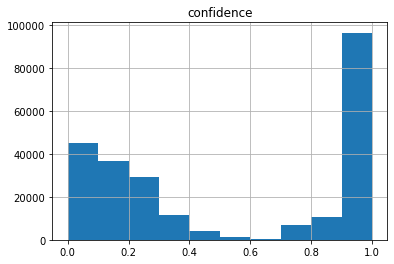

In [4]:
# Analysing the data confidence level
df.hist(column='confidence');


We want to filter the low confidence eye measurements from the data as these are generally quite inaccurate (in correlation to the adjacent more confident measurements). There is also a clear distinction in the histogram between high-confidence (>0.6) measurements and low-confidence ones.

We also take only relevant columns for analysis. Excluding the preliminary pupil parameters for instance.

In [5]:
# Keep the relevant columns
relevant = ['time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z', 'confidence', 'gender', 'F_x', 'F_y', 'F_z' ] # Added in F values for later
df = df[relevant]


In [6]:
# More data cleaning
# Drop repeated consecutive times (drop first)
df = df.loc[df['time'].shift() != df['time']]

# Drop row at time 0.000 (index 1) as these are not accurate
df = df.loc[df['time'] != 0.000]

# Keep only confident eye tracking coords for eye path analysis
df_eye = df[df['confidence'] > 0.6]

# Remove some outlier PoG eye measurments (some are outside of the room coordinates)
df_eye = df_eye[(df_eye['L_x'] >= -23.9) & (df_eye['L_x'] <= -9)]
df_eye = df_eye[(df_eye['L_y'] >= 0) & (df_eye['L_y'] <= 3.7)]
df_eye = df_eye[(df_eye['L_z'] >= -9.7) & (df_eye['L_z'] <= 0.4)]

df.drop(['L_x', 'L_y', 'L_z'], axis=1, inplace=True)
df_eye.drop(['time', 'C_x', 'C_y', 'C_z', 'confidence', 'gender'], axis=1, inplace=True)


In [7]:
# Merge back in filtered eye data
df = pd.merge(df.reset_index(), df_eye.reset_index(), how='left', on=['id', 'index']).set_index(keys=['id', 'index'])


In [8]:
# The dataset after cleaning is below --> IS THIS CORRECT --> IT IS AS THE CONFIDENCE ONLY APPLIES TO EYE (L) VALUES 
df


time   C_x  C_y  C_z  confidence gender  F_x_x  F_y_x  F_z_x  \
id index                                                                    
1  2        0.068 -19.8  1.8 -4.2    0.239798      m    1.0   -0.2    0.0   
   3        0.100 -19.9  1.7 -4.2    0.231661      m    1.0    0.0   -0.2   
   4        0.168 -19.9  1.7 -4.2    0.209350      m    1.0    0.0   -0.2   
   5        0.200 -19.9  1.7 -4.2    0.147285      m    1.0    0.0   -0.2   
   6        0.264 -19.9  1.7 -4.2    0.049389      m    1.0    0.0   -0.2   
...           ...   ...  ...  ...         ...    ...    ...    ...    ...   
9  3349   121.690 -14.5  1.7 -2.6    0.000000      m    1.0    0.1   -0.1   
   3350   121.720 -14.5  1.7 -2.6    0.000000      m    1.0    0.1   -0.1   
   3351   121.790 -14.5  1.7 -2.6    0.000000      m    1.0    0.1   -0.1   
   3352   121.830 -14.5  1.7 -2.6    0.872781      m    1.0    0.1   -0.1   
   3353   121.860 -14.5  1.7 -2.6    0.840529      m    1.0    0.1   -0.1   

          L_x  L_y  L_z  F_x_y  F_y_y  F_z_y  
id index                                      
1  2      NaN  NaN  NaN    NaN    NaN    NaN  
   3      NaN  NaN  NaN    NaN    NaN    NaN  
   4      NaN  NaN  NaN    NaN    NaN    NaN  
   5      NaN  NaN  NaN    NaN    NaN    NaN  
   6      NaN  NaN  NaN    NaN    NaN    NaN  
...       ...  ...  ...    ...    ...    ...  
9  3349   NaN  NaN  NaN    NaN    NaN    NaN  
   3350   NaN  NaN  NaN    NaN    NaN    NaN  
   3351   NaN  NaN  NaN    NaN    NaN    NaN  
   3352  -9.3  1.7 -3.7    1.0    0.1   -0.1  
   3353  -9.3  1.7 -3.7    1.0    0.1   -0.1  

[164122 rows x 15 columns]

C:\Users\hashi\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\hashi\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


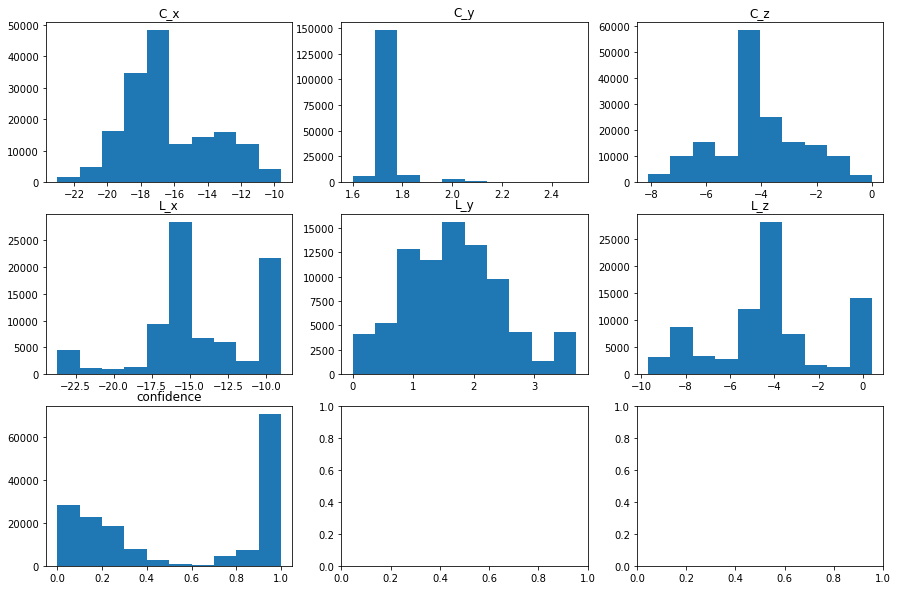

In [9]:
# Plotting the columns to see the spread of each variable
fig, axs = plt.subplots(3, 3, figsize=(15,10))
for i, col in enumerate(['C_x', 'C_y', 'C_z', 'L_x', 'L_y', 'L_z', "confidence"]):
  axs[i//3, i%3].hist(df[col])
  axs[i//3, i%3].set_title(col)


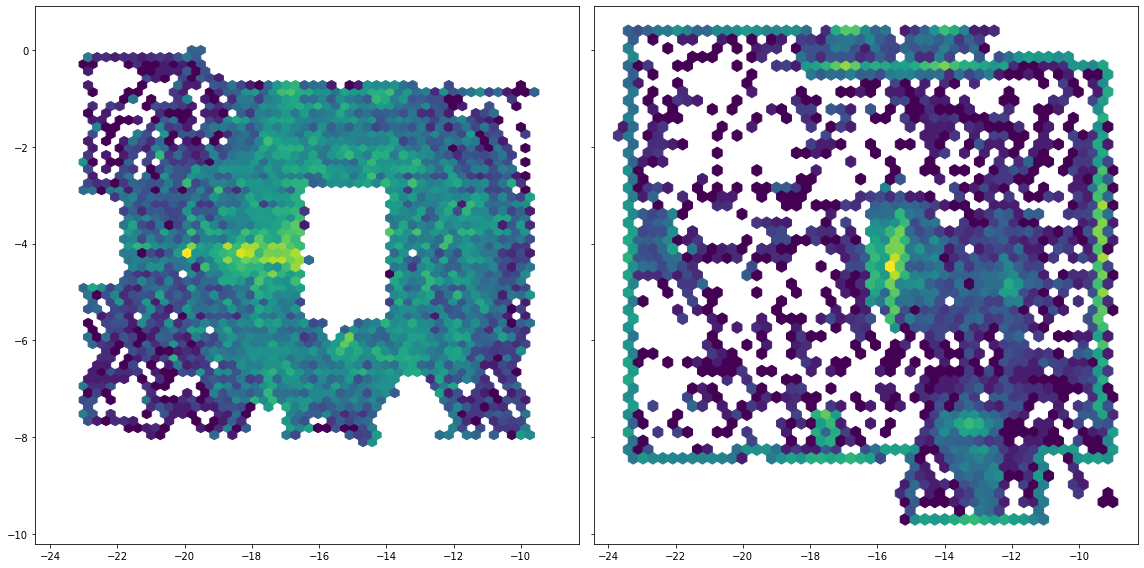

In [10]:
# Plotting where the common points where users stand and the points of attraction
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)

pc = ax[0].hexbin(df['C_x'], df['C_z'], cmap='viridis', mincnt=1, gridsize=50, bins='log')
pc = ax[1].hexbin(df['L_x'], df['L_z'], cmap='viridis', mincnt=1, gridsize=50, bins='log')
fig.tight_layout()


Clear to see that the predominant area for users to stand in is central around the main attraction of the museum, in particular the main information panel.

Again this main information panel is very apparent in the PoG data, and the other areas of interest, the museum exhibits are clearly discernable as high density patches. 
And the other which users focus on is the walls.

In [11]:
# Camera Y position should be fixed (only variance comes from jitter and is not relevant for analysis)
df.drop('C_y', axis=1, inplace=True)


## Metrics

Here we generate trajectory metrics (based on the camera position) which can be used in analysis or used for further techniques such as path segmentation.
Eye tracking metrics will be performed later and in relation to segmented paths.

In [12]:
import math
def distance_3d(x1, y1, z1, x2, y2, z2):
  return math.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)

def distance_2d(x1, z1, x2, z2):
  return math.sqrt((x2-x1)**2 + (z2-z1)**2)

def bearing_2d(x1, z1, x2, z2):
  return abs(math.atan2(x2 - x1, z2 - z1))

In [13]:
C_metrics = {}

for id in df.reset_index().id.unique():
  user_df = df.loc[id]
  pt = user_df.iloc[0, 0]
  px, pz = user_df.iloc[0, 1:3]
  pbearing = 0

  distances = []
  velocities = []
  times = []
  turning_angles = []
  for j in range(1, len(user_df.iloc[1:, 1:3]) + 1):
    x, z = user_df.iloc[j, 1:3]
    t = user_df.iloc[j, 0]
    d = distance_2d(px, pz, x, z)
    distances.append(d)
    velocities.append(d / (t - pt))
    times.append(t)

    bearing = bearing_2d(x, z, px, pz)
    turning_angles.append(abs(bearing - pbearing))

    px, pz, pt = x, z, t
    pbearing = bearing

  C_metrics[id] = {'v': velocities, 't': times, 'step_d': distances, 'heading_change' : turning_angles}

In [14]:
random.seed(747)
sample = random.sample(C_metrics.keys(), 10)

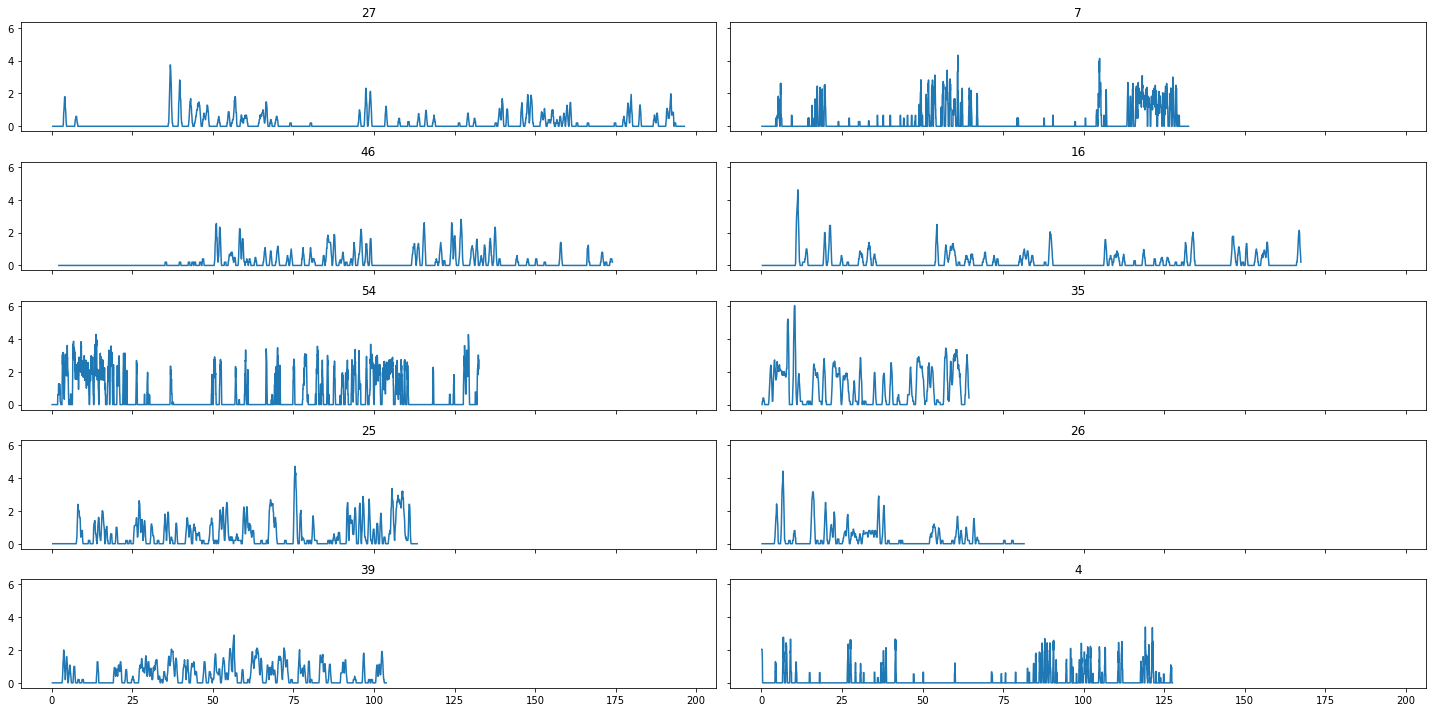

In [15]:
# Plot smoothed moving average speeds
window = 5

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

for k in C_metrics.keys():
    C_metrics[k]['ma_v'] = moving_average(C_metrics[k]['v'], window)

fig, ax = plt.subplots(5, 2, figsize=(20,10), sharey=True, sharex=True)

for i, k in enumerate(sample):
    ax[i//ax.shape[1], i%ax.shape[1]].plot(C_metrics[k]['t'][:-window + 1], C_metrics[k]['ma_v'])
    ax[i//ax.shape[1], i%ax.shape[1]].set_title(k)

fig.tight_layout()

Path segmentation approaches

- Basic change point analysis of users staying still for n seconds
- PELT algorithm
    - applicable due to regular time sampling and the aim of change point detection
    - DOI 10.1186/s40462-016-0086-5
    - and https://arxiv.org/pdf/1101.1438.pdf

In [16]:
# Create path segmentations where users stay still for n seconds to look at something
# Type of simple change point analysis

# New paths start when movement begins again

# Number of seconds to break path on no movement
path_break = 1

for k, v in C_metrics.items():
    path_breaks = []
    last_motion = 0 # time of last motion
    waiting_for_next_motion = True
    for i, vel in enumerate(v['v']):
        if vel != 0:
            last_motion = v['t'][i]
            if waiting_for_next_motion:
                path_breaks.append(i)
                waiting_for_next_motion = False
        elif v['t'][i] - last_motion > path_break:
            waiting_for_next_motion = True
    path_breaks.append(len(v['v']))
    C_metrics[k]['path_breaks'] = path_breaks

print(C_metrics['3']['path_breaks'])

[1, 198, 260, 386, 456, 896, 967, 1069, 1285, 1645, 1742, 1876, 1979, 2101, 2240, 2406, 2608, 2698, 2711]


In [17]:
# More sophisticated PELT changepoint detection of paths

# PELT Path Segmentation Algorithm
# Implementation from https://github.com/nicodesh/pelt-algorithm/blob/master/pelt.py
# https://arxiv.org/pdf/1101.1438.pdf

def pelt(data, **kwargs):
    # Pre-processing
    df = pd.DataFrame(data)
    df['squared'] = np.square(df[0])
    df['cumsum'] = np.cumsum(df[0], axis=0)
    df['cumsumsquared'] = np.cumsum(df['squared'], axis=0)
    df['diviseur'] = [x for x in range(1,len(df)+1)]
    df['mean'] = df['cumsum'] / df['diviseur']
    df['meansquared'] = np.square(df['mean'])
    df = df.append({
        0:0,
        'cumsum':0,
        'cumsumsquared':0,
        'diviseur':0,
        'mean':0,
        'meansquared':0,
        'squared':0}, ignore_index=True)
    
    # Penalty
    if 'penalty' in kwargs:
        B = kwargs['penalty']
    else:
        B = 2 * np.log(len(data))
    
    # Initilization
    Q = [-B] # Actual cost
    CP = [-1] # Last segment position
    T = [x for x in range(0,len(data))] # Authorized positions

    # Parse the data
    for pos in range(0,len(data)):
        
        costs = []
        min_cost_val_temp = float("inf")
        min_cost_pos_temp = -1
        
        # Parse all the Yi:pos that are still available
        for i in T:
            if i > pos:
                break

            # Square sum minus N times the square mean
            sos = df['cumsumsquared'].iloc[pos] - df['cumsumsquared'].iloc[i-1]
            n = pos - i + 1
            ms = (data[i:pos+1].mean())**2
            C = sos - (n*ms)

            # Cost test
            temp_cost = Q[i] + C + B
            if min_cost_val_temp > temp_cost:
                min_cost_val_temp = temp_cost
                min_cost_val_pos = i

        # Push the smallest cost
        Q.append(min_cost_val_temp)

        # Push the position
        CP.append(min_cost_val_pos)
        
        # Prunning
        for i in T:
            if i >= pos:
                break
            
            iplusone = i+1
            # Square sum minus N times the square mean
            sos = df['cumsumsquared'].iloc[pos] - df['cumsumsquared'].iloc[iplusone-1]
            n = pos - iplusone + 1
            ms = (data[iplusone:pos+1].mean())**2
            C = sos - (n*ms)
                
            if (Q[i] + C > Q[pos]):
                T.remove(i)
                
    return CP

def backtracking(CP):
    """ Apply backtracking to a CP vector from OP algorithm. Returns a "segments" vector.
    Args:
     CP: array-like 1 dimension.
    """

    # Data length
    n = len(CP)-1

    # Initialization
    segments = []
    changepoint = CP[n]

    # While the changepoint doesn't return the first point
    while changepoint > 0:

        segments.append(changepoint-1)
        changepoint = CP[changepoint]

    # The new vector was built with .append(), but since we parse from the end to the beginning,
    # We need to reverse it.
    segments.reverse()
    segments.append(n)
    return segments

# Commented as get more intuitive results with non-pelt
# for k, v in C_metrics.items():
#     cp = pelt(np.array(v['v']))
#     pb = backtracking(cp)
#     pb.insert(0, C_metrics[k]['path_breaks'][0]) # Add the first movement as start of trajectories
#     C_metrics[k]['path_breaks'] = sorted(list(dict.fromkeys(pb)))

Visualize path segments

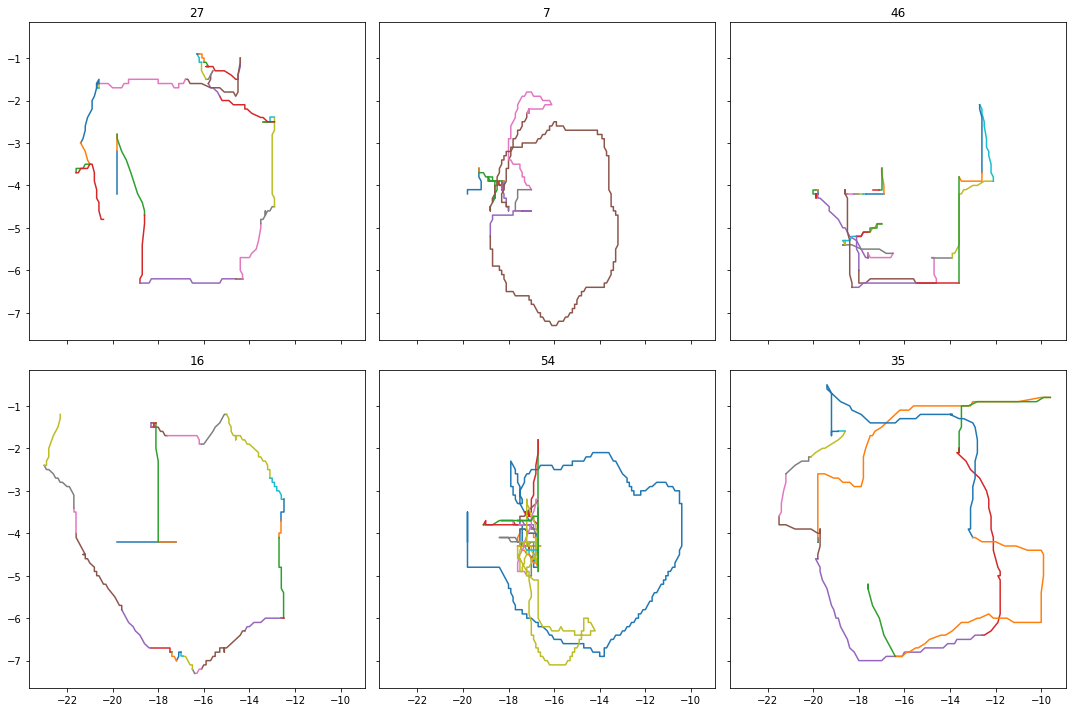

In [18]:
# fig, ax = plt.subplots(5, 2, figsize=(20,10), sharey=True, sharex=True)
# for i, k in enumerate(sample):
#     ex = C_metrics[k]
#     for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
#         path_end -= 1
#         if path_end > len(ex['ma_v']):
#             path_end -= window + 1
#         ax[i//ax.shape[1], i%ax.shape[1]].plot(ex['t'][path_start:path_end], ex['ma_v'][path_start:path_end])
#         ax[i//ax.shape[1], i%ax.shape[1]].set_title(k)
# fig.tight_layout()

fig, ax = plt.subplots(2, 3, figsize=(15,10), sharey=True, sharex=True)

for i, k in enumerate(sample[:ax.size]):
    ex = C_metrics[k]
    user_df = df.loc[k]
    for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
        path_end += 1
        
        ax[i//ax.shape[1], i%ax.shape[1]].plot(user_df['C_x'].iloc[path_start:path_end], user_df['C_z'].iloc[path_start:path_end])
        ax[i//ax.shape[1], i%ax.shape[1]].set_title(k)
fig.tight_layout()

Here we create metrics for the path segments individually

- Straightness, velocity, path length, total displacement

In [19]:
# Straigtness calculated as D/L as per https://doi.org/10.1016/j.jtbi.2004.03.016
# Path velocities also calculated
# User rdp to rediscretize to a defined steplength to calculate sinuosity

for k, v in C_metrics.items():
    user_df = df.loc[k]
    straightness = []
    velocities = []
    lengths = []
    displacements = []
    times = []
    sinuosities = []

    for path_start, path_end in zip(v['path_breaks'], v['path_breaks'][1:]):
        s, e = user_df.iloc[path_start], user_df.iloc[path_end - 1]
        D = distance_2d(s['C_x'], s['C_z'], e['C_x'], e['C_z'])
        L = 0
        for i in range(path_start, path_end):
            L += v['step_d'][i] * 30
        if (L == 0):
            straightness.append(1)
        else:
            if L < D:
                print(D, L)
            straightness.append(D/L)
        velocities.append(np.mean(v['v'][path_start:path_end]))

        # Exclude end 2+ seconds of stillness from the average velocity
        # Only for basic non-pelt segmentation
        # velocities.append(np.mean(v['v'][path_start:path_end][:np.max(np.nonzero(v['v'][path_start:path_end])) + 1]))
        
        lengths.append(L)
        displacements.append(D)
        times.append(e['time'] - s['time'])

        # Sinuosities over reparameterized coordinates
        # turning_angles = []
        # pbearing = 0
        # px, pz = s['C_x'], s['C_z']
        # for (x, z) in rdp(user_df.iloc[path_start+1:path_end-1][['C_x', 'C_z']].to_numpy(), 0.001):
        #     bearing = bearing_2d(x, z, px, pz)
        #     turning_angles.append(bearing - pbearing)
        #     px, pz, pbearing = x, z, bearing
        # # sinuosities.append(1.18 * np.std(turning_angles) / math.sqrt(0.1))
        # sinuosities.append(np.mean(np.cos(turning_angles)))


    C_metrics[k]['path_straightness'] = straightness
    C_metrics[k]['path_velocities'] = velocities
    C_metrics[k]['path_lengths'] = lengths
    C_metrics[k]['path_displacements'] = displacements
    C_metrics[k]['path_times'] = times
    # C_metrics[k]['path_sinuosities'] = sinuosities


Visualize path straightness as a metric

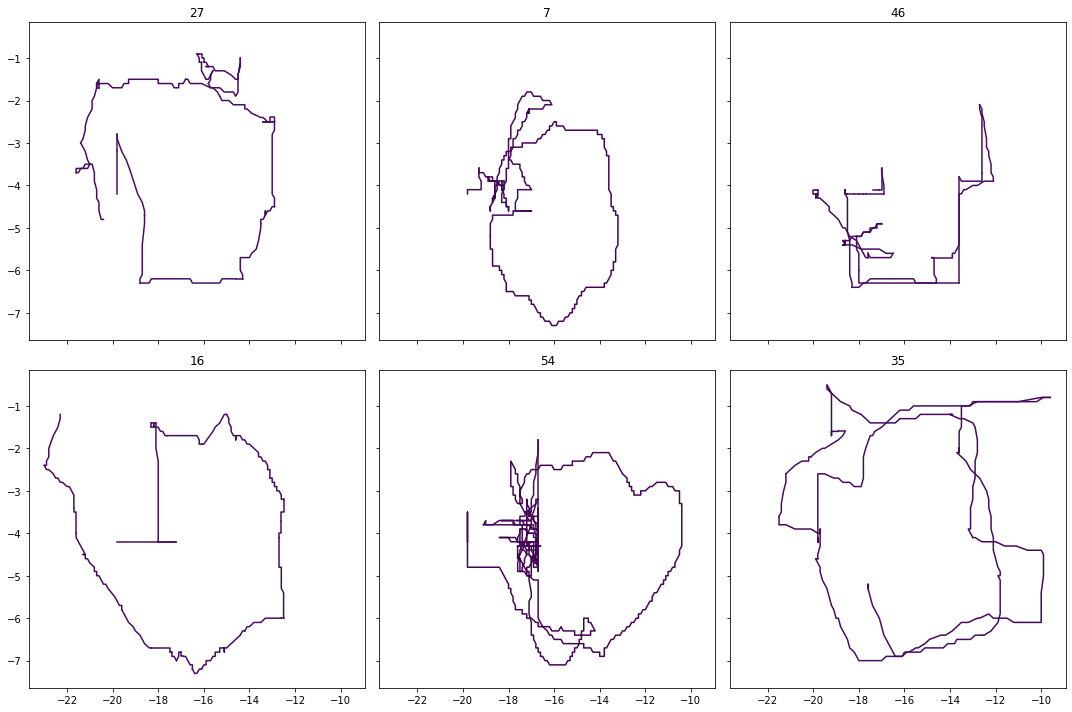

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)

norm = plt.Normalize(0, 1)
cm_norm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

for i, k in enumerate(sample[:ax.size]):
    ex = C_metrics[k]
    user_df = df.loc[k]
    for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
        path_end += 1
        ax[i//ax.shape[1], i % ax.shape[1]
           ].plot(user_df['C_x'].iloc[path_start:path_end], user_df['C_z'].iloc[path_start:path_end], color=cm_norm.to_rgba(ex['path_straightness'][ex['path_breaks'].index(path_start)]))
        ax[i//ax.shape[1], i % ax.shape[1]].set_title(k)

fig.tight_layout()
# fig.colorbar(cm_norm)


The below illustrates how different users have different movement profiles.

For example user 19 moves in typically straighter paths, noticeable in comparison to user 39.

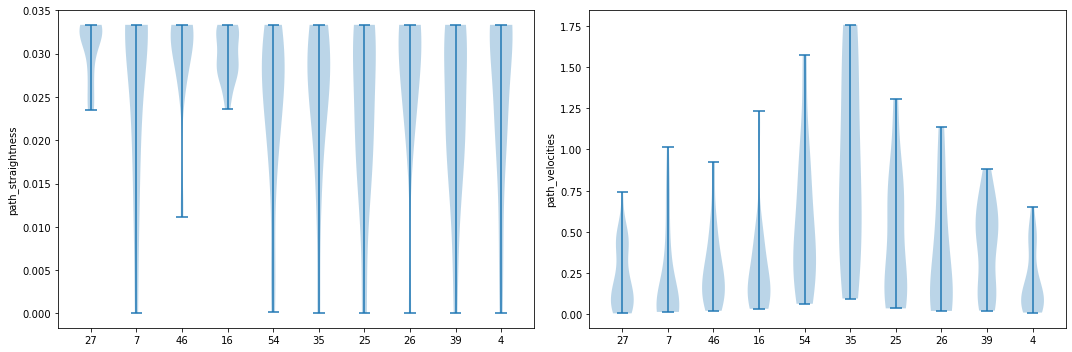

In [21]:
# Violin Plots of straightness by user, illustrate different exploration patterns per person
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

for i, cat in enumerate(['path_straightness', 'path_velocities']):
    selected = [C_metrics[j][cat] for j in sample]
    ax[i].violinplot(selected);
    ax[i].set_xticks(np.arange(1, len(sample) + 1));
    ax[i].set_xticklabels(sample);
    ax[i].set_ylabel(cat);

fig.tight_layout()


There is not an obvious relationship between path length and path straightness, however the longest paths do tend to be less straight.

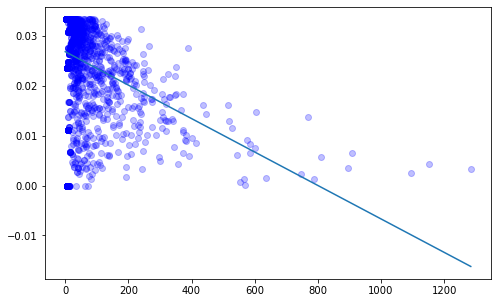

In [22]:
fig, ax = plt.subplots(figsize=(8,5))

all_t, all_sin = [], []
for k, ex in C_metrics.items():
    all_t.extend(ex['path_lengths'])
    all_sin.extend(ex['path_straightness'])

m, b = np.polyfit(all_t, all_sin, 1)
x = np.array([i for i in range(0, round(max(all_t)), 1)])

ax.scatter(all_t, all_sin, color='b', alpha=0.25)
ax.plot(x, m*x + b)

## Clustering Paths by Metrics

In [23]:
# Create dataframe of paths (metrics and coordinate arrays)
from rdp import rdp

path_df = pd.DataFrame(columns=['user_id', 'straightness', 'average_velocity', 'time', 'length',
                                'displacement', 'C_coords', 'L_coords', 'C_coords_rdp', 'gender'])

for k, ex in C_metrics.items():
    user_df = df.loc[k]
    for i, (path_start, path_end) in enumerate(zip(ex['path_breaks'], ex['path_breaks'][1:])):
        row = {}
        row['user_id'] = k
        row['straightness'] = ex['path_straightness'][i]
        row['average_velocity'] = ex['path_velocities'][i]
        row['time'] = ex['path_times'][i]
        row['length'] = ex['path_lengths'][i]
        row['displacement'] = ex['path_displacements'][i]
        row['C_coords'] = user_df.iloc[path_start:path_end][['C_x', 'C_z']].to_numpy()
        row['L_coords'] = user_df.iloc[path_start:path_end][['L_x', 'L_y', 'L_z']].to_numpy()
        row['C_coords_rdp'] = rdp(row['C_coords'], 0.0001)
        row['gender'] = user_df.iloc[0]['gender']
        path_df = path_df.append(row, ignore_index=True)

path_df['gender'] = path_df['gender'].astype("category")
path_df['straightness'] = path_df['straightness'].astype("float64")


In [24]:
path_df.head()

,user_id,straightness,average_velocity,time,length,displacement,C_coords,L_coords,C_coords_rdp,gender
0,1,0.011111,0.018638,17.632,9.000000,0.100000,"[[-19.8, -4.2], [-19.9, -4.2], [-19.9, -4.2], ...","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...","[[-19.8, -4.2], [-19.9, -4.2]]",m
1,1,0.033333,0.036523,2.472,3.000000,0.100000,"[[-19.9, -4.2], [-19.8, -4.2], [-19.8, -4.2], ...","[[-15.5, 2.2, -3.9], [-15.5, 2.2, -3.9], [-15....","[[-19.9, -4.2], [-19.8, -4.2]]",m
2,1,0.027971,0.827994,1.484,33.727922,0.943398,"[[-19.8, -4.2], [-19.8, -4.1], [-19.8, -4.1], ...","[[-15.5, 2.4, -4.4], [-15.5, 2.4, -4.4], [-15....","[[-19.8, -4.2], [-19.8, -4.1], [-19.7, -4.1], ...",m
3,1,0.025855,0.273450,5.372,43.242641,1.118034,"[[-19.0, -3.7], [-19.0, -3.6], [-19.0, -3.6], ...","[[-9.3, 2.9, -5.7], [-9.3, 2.9, -5.7], [-9.3, ...","[[-19.0, -3.7], [-19.0, -3.6], [-19.0, -3.7], ...",m
4,1,0.027487,0.073756,6.296,15.000000,0.412311,"[[-17.9, -3.9], [-17.8, -3.9], [-17.8, -3.9], ...","[[-9.3, 3.2, -5.4], [-9.3, 3.2, -5.5], [-9.3, ...","[[-17.9, -3.9], [-17.8, -3.9], [-17.8, -4.0], ...",m


0    841
3    402
5    204
1    108
6     44
2     13
4      6
7      3
Name: cluster, dtype: int64

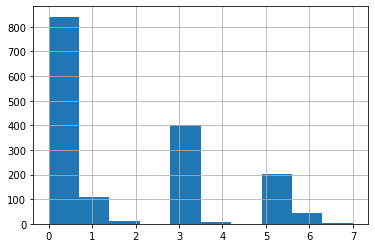

In [25]:
# Cluster paths by metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

n_clusters = 8

clustering = KMeans(n_clusters=n_clusters, n_init=50, max_iter=500, ).fit(path_df[['straightness', 'average_velocity', 'displacement', 'length', 'time']].to_numpy())
# clustering = DBSCAN(eps=0.4, min_samples=5).fit(path_df[['straightness', 'average_velocity', 'displacement', 'length', 'time']].to_numpy())
path_df['cluster'] = clustering.labels_
path_df['cluster'] = path_df['cluster'].astype("category")
path_df['cluster'].hist()

n_clusters = len(np.unique(clustering.labels_))
path_df['cluster'].value_counts()

### Frechet Path Distances and BDSCAN Clustering

Not as effective at discerning different path types (i.e. short sinuous ones vs long wandering)

In [26]:
# from tqdm import tqdm
# import multiprocessing as mp

## Cluster by path similarity measures (frechet)
# import similaritymeasures

# n = len(path_df)

# pbar = tqdm(total=n)

# def dist_row(i):
#     r = np.zeros(n)
#     for j in range(i + 1, n):
#         r[j] = similaritymeasures.frechet_dist(
#             path_df.iloc[i]['C_coords_rdp'], path_df.iloc[j]['C_coords_rdp'])
#     pbar.update(1)
#     return r


# pool = mp.Pool(4)
# results = pool.map(dist_row, range(n))
# results = np.array(results)
# np.save('frechet_matrix.npy', results)
# for i in range(n):
#     for j in range(i+1, n):
#         results[j, i] = results[i, j]

# clustering = DBSCAN(eps=0.5, min_samples=5, metric='precomputed')
# clustering.fit(results)
# path_df['cluster'] = clustering.labels_ + 1

# path_df['cluster'].hist()

# n_clusters = len(np.unique(clustering.labels_))
# path_df['cluster'].value_counts()


### Visualizing path clusters

There are distinct types, the short high straightness movements, and longer wandering paths which curve around the room. The clustering has further broken these types by the metrics (most noticeably time) which can be seen in the violin plots below.

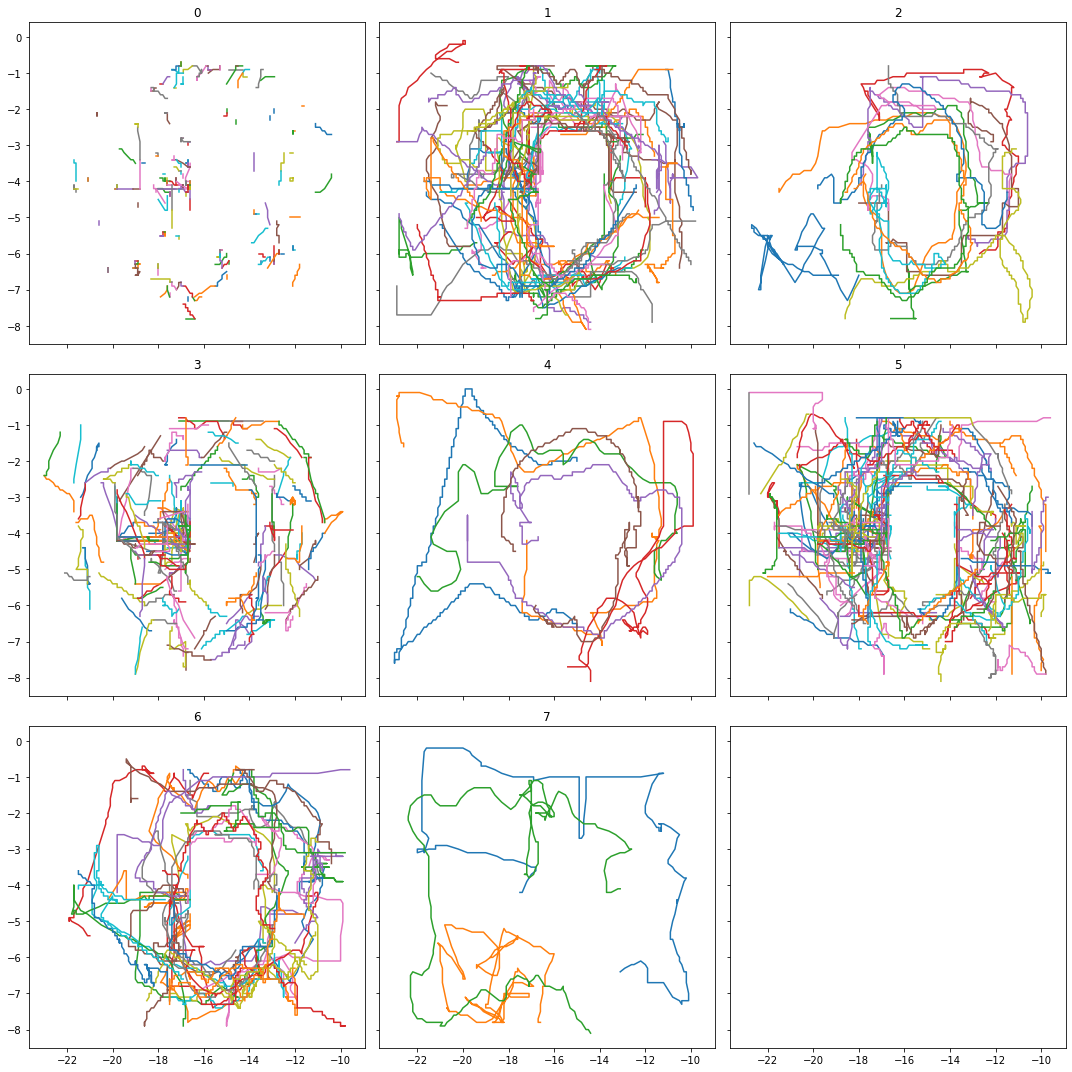

In [27]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharey=True, sharex=True)

for i in range(n_clusters):
    # Plot only 100 from each cluster to reduce noise
    for line in path_df[path_df['cluster'] == i]['C_coords_rdp'].to_list()[:200]:
        ax[i//ax.shape[1], i % ax.shape[1]].plot(line[:, 0], line[:, 1])
    ax[i//ax.shape[1], i % ax.shape[1]].set_title(i)
fig.tight_layout()

<ipython-input-28-da4753aff62a>:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


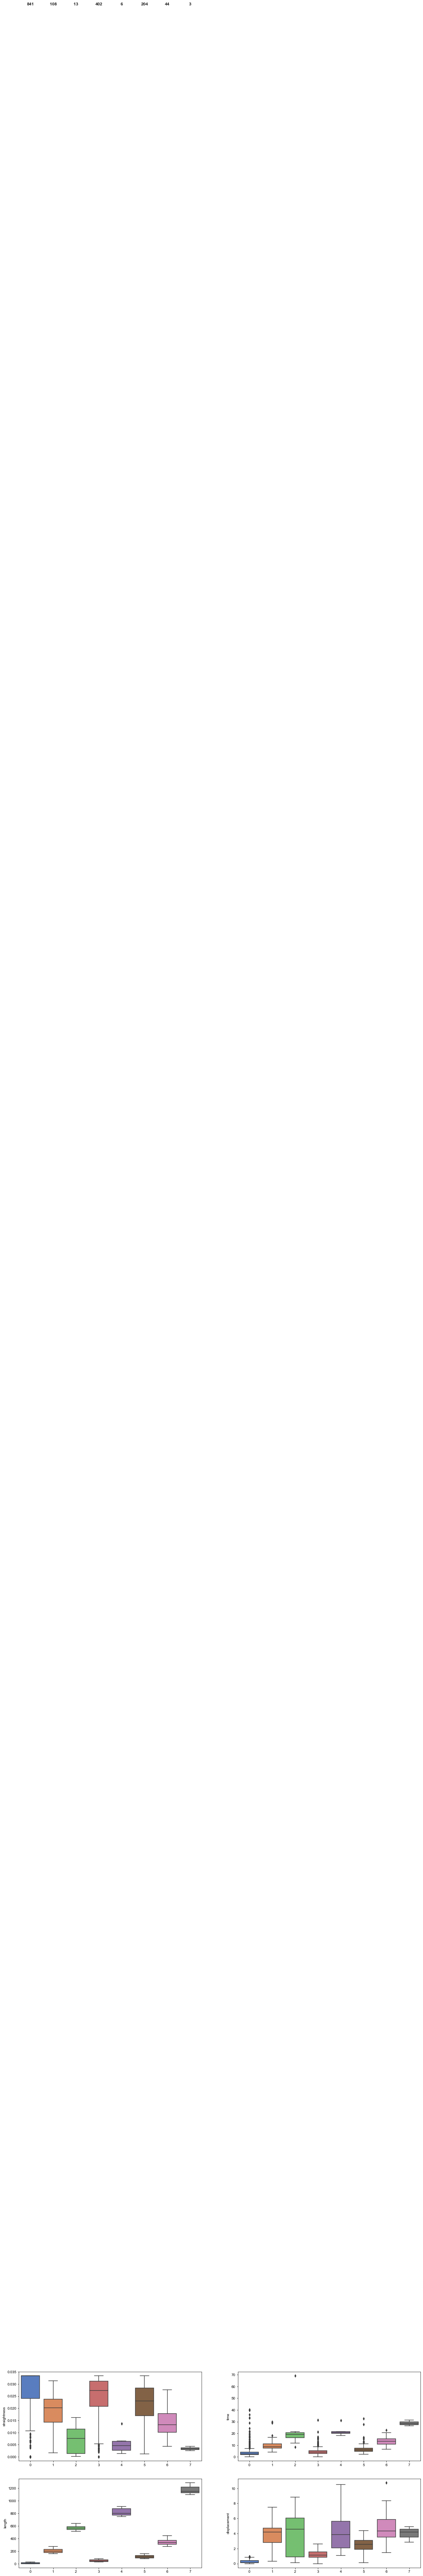

In [28]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme(style="whitegrid", palette="muted")

nobs = [str(len(path_df[path_df['cluster'] == x])) for x in range(n_clusters)]

sns.boxplot(data=path_df, x="cluster", y="straightness", ax=ax[0, 0])

pos = range(len(nobs))
for tick,label in zip(pos,ax[0, 0].get_xticklabels()):
    ax[0, 0].text(pos[tick], 1.01, nobs[tick], horizontalalignment='center', weight='bold')
ax[0, 0].set_xlabel('')

sns.boxplot(data=path_df, x="cluster", y="time", ax=ax[0, 1])
ax[0, 1].set_xlabel('')

sns.boxplot(data=path_df, x="cluster", y="length", ax=ax[1, 0])
ax[1, 0].set_xlabel('')

sns.boxplot(data=path_df, x="cluster", y="displacement", ax=ax[1, 1])
ax[1, 1].set_xlabel('')

fig.tight_layout()

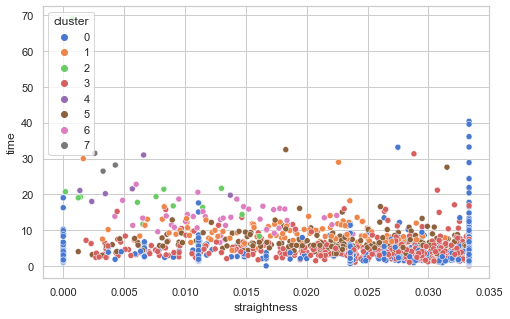

In [29]:
fig, ax = plt.subplots(figsize=(8,5))

sns.scatterplot(data=path_df, x='straightness', y='time', hue='cluster')

## Gender Analysis of Movement Data

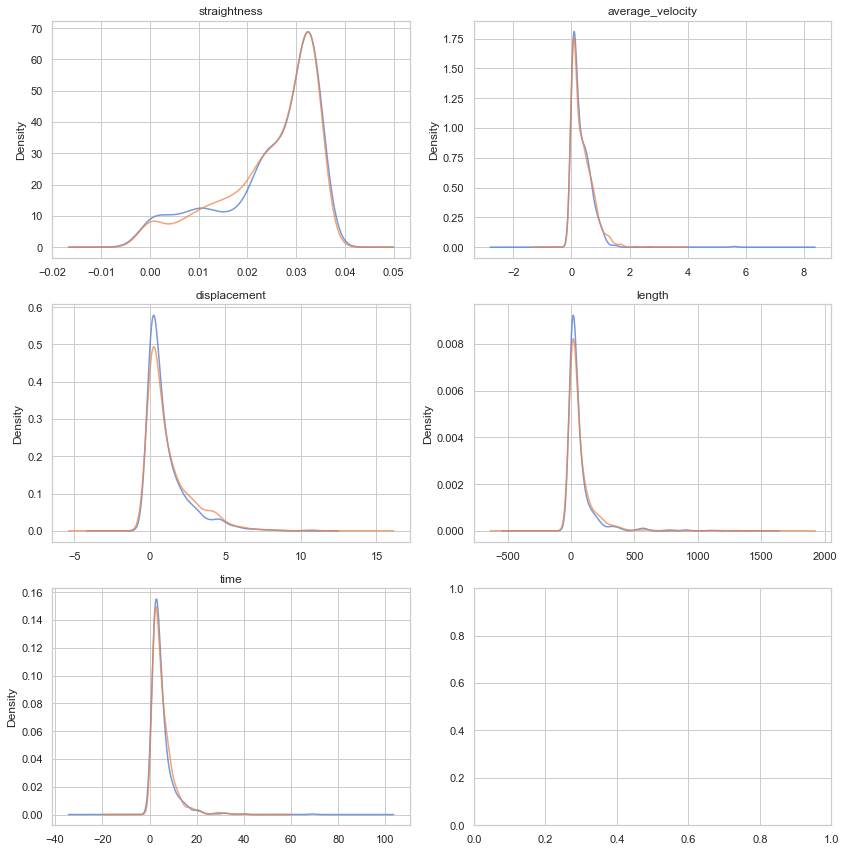

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

for i, cat in enumerate(['straightness', 'average_velocity', 'displacement', 'length', 'time']):
    path_df.groupby('gender')[cat].plot.kde(alpha=0.75, ax=ax[i//ax.shape[1], i % ax.shape[1]])
    ax[i//ax.shape[1], i % ax.shape[1]].set_title(cat)

fig.tight_layout()

There is no discernable difference between the path movement patterns between genders. The descriptive statistics for the path segments by gender are nearly identical in all cases. 

# PART 2 (Head and Eye Direction Analysis)

<ipython-input-36-3b1d86c5c7e3>:34: RuntimeWarning: divide by zero encountered in double_scalars
  m = (L_z - C_z) / (L_x - C_x)


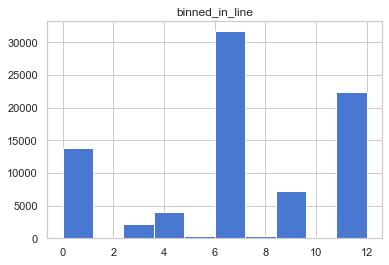

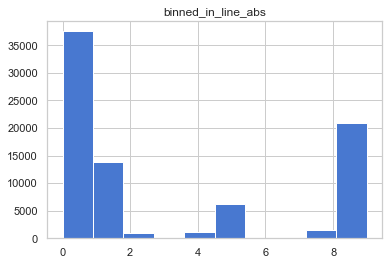

In [36]:
# Do focus points and head direction tend to correlate? 

# F_x and F_z as we want to know the direction of where the head is pointed in a 2D space (as movement here is 2D)
# L_x (where their eyes are) and C_x (where their body is) instead of how their head is orientated
df_focus = df_eye[["F_x", "F_z", "L_x", "L_z"]]
df_head = df[["C_x", "C_z"]]
df_focus_head = pd.merge(df_focus, df_head, left_index = True, right_index = True)

# Mod function
def mod(a, n):
    return ((a % n + n) % n)

# Finding the angle of F from the normal line (0, 1). As F is just the direction the head is orientated
def calculate_angle(x, z):
    angle = 0
    if ((x > 0) and (z > 0)):
        angle = 90 - (np.arctan(abs(z) / abs(x)) * (180/3.14159))
    if ((x > 0) and (z < 0)):
        angle = 90 + (np.arctan(abs(z) / abs(x)) * (180/3.14159))
    if ((x < 0) and (z < 0)):
        angle = -(90 + (np.arctan(abs(z) / abs(x)) * (180/3.14159)))
    if ((x < 0) and (z > 0)):
        angle = -(90 - (np.arctan(abs(z) / abs(x)) * (180/3.14159)))
    return angle

# Applying the function and adds the result to the df
#calculate_angle(df_focus_head["L_x"], df_focus_head["L_z"])
df_focus_head["head_angle"] = df_focus_head.apply(lambda x: calculate_angle(x["F_x"], x["F_z"]), axis=1)
    
# L values must be calculated in relation to the body (as values are taken from the origin, not the body)
# Finding the angle from the line made by the two points and the normal line (0, 1)
def calculate_angle_focus(L_x, L_z, C_x, C_z):
    angle = 0
    m = (L_z - C_z) / (L_x - C_x)
    angle_m = (np.arctan(m) * (180/3.14159))
    angle = 90 - angle_m
#    if angle < 0:
#        angle = angle + 360
    if C_z > L_z: # Their focus is below their body - looking southward
        angle = angle - 180
    if angle > 180:
        angle = angle - 360
    if angle < -180:
        angle = angle + 360
#        while angle < 0:
#            angle = angle + 360
    return angle

# Applying the function and adds the result to the df
df_focus_head["focus_angle"] = df_focus_head.apply(lambda y: calculate_angle_focus(y["L_x"], y["L_z"], y["C_x"], y["C_z"]), axis=1)

# df_focus_head["in_line"] = (abs(df_focus_head["head_angle"] - df_focus_head["focus_angle"])/((df_focus_head["head_angle"] + df_focus_head["focus_angle"])/2)) * 100

# Function to find the difference between the head and focus angles
def angle_diff(head_angle, focus_angle):
    angle_diff = head_angle - focus_angle
    angle_diff = (mod((angle_diff + 180), 360)) - 180
    return angle_diff

# Applying the function and adds the result to the df
df_focus_head["in_line"] = df_focus_head.apply(lambda z: angle_diff(z["head_angle"], z["focus_angle"]), axis=1)

# Function to find the absolute difference between the head and focus angles
def angle_diff_abs(head_angle, focus_angle):
    angle_diff = abs(head_angle - focus_angle)
    angle_diff = (mod((angle_diff + 180), 360)) - 180
    if angle_diff > 180:
        return abs(angle_diff - 360)
    if angle_diff < -180:
        return abs(angle_diff + 360)
    if -180 <= angle_diff <= 180:
        return abs(angle_diff)

# Applying the function and adds the result to the df
df_focus_head["in_line_abs"] = df_focus_head.apply(lambda a: angle_diff_abs(a["head_angle"], a["focus_angle"]), axis=1)

# Bin and plot the results of these differences
bins = [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180]
df_focus_head["binned_in_line"] = np.searchsorted(bins, df_focus_head["in_line"].values)
df_focus_head.hist(column="binned_in_line");

bins_2 = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]
df_focus_head["binned_in_line_abs"] = np.searchsorted(bins_2, df_focus_head["in_line"].values)
df_focus_head.hist(column="binned_in_line_abs");


# Visualising Head and Eye Direction

,F_x,F_z,L_x,L_z,C_x,C_z,head_angle,focus_angle,in_line,in_line_abs,binned_in_line,binned_in_line_abs,head_angle_binned,focus_angle_binned
count,82361.000000,82361.000000,82361.000000,82361.000000,82361.000000,82361.000000,82361.000000,82361.000000,82361.000000,82361.000000,82361.000000,82361.000000,82361.000000,82361.000000
mean,0.581694,-0.026770,-14.245430,-4.283094,-16.541663,-3.987614,43.733225,-15.518904,18.343931,93.636278,7.055330,3.063246,12.585836,9.710130
std,0.614954,0.516279,3.773875,2.561902,2.575143,1.467808,79.466573,85.728288,119.347460,76.239498,3.789368,3.831358,4.035466,4.332027
min,-1.000000,-1.000000,-23.700000,-9.700000,-23.000000,-8.100000,-174.289478,-179.215251,-180.000000,0.000000,0.000000,0.000000,2.000000,2.000000
25%,0.300000,-0.300000,-15.900000,-5.300000,-18.200000,-4.500000,0.000000,-83.659803,-28.959929,6.699289,6.000000,0.000000,10.000000,6.000000
50%,0.900000,0.000000,-15.300000,-4.400000,-17.200000,-4.200000,77.471182,-46.397144,1.956213,88.264294,7.000000,1.000000,14.000000,8.000000
75%,1.000000,0.200000,-9.500000,-3.300000,-14.700000,-3.200000,95.710598,75.963745,161.095408,175.173137,12.000000,9.000000,15.000000,14.000000
max,1.000000,1.000000,-9.000000,0.400000,-9.600000,0.000000,174.289478,179.204352,180.000000,180.000000,12.000000,9.000000,19.000000,19.000000


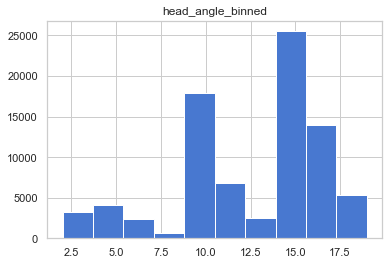

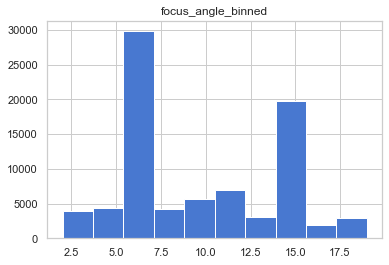

In [37]:
# Place the focus and head angle values into bins and plot their spread
bins_2 = [-1000, -180, -160, -140, -120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 1000]
df_focus_head["head_angle_binned"] = np.searchsorted(bins_2, df_focus_head["head_angle"].values)
df_focus_head.hist(column="head_angle_binned");

df_focus_head["focus_angle_binned"] = np.searchsorted(bins_2, df_focus_head["focus_angle"].values)
df_focus_head.hist(column="focus_angle_binned");

df_focus_head.describe()


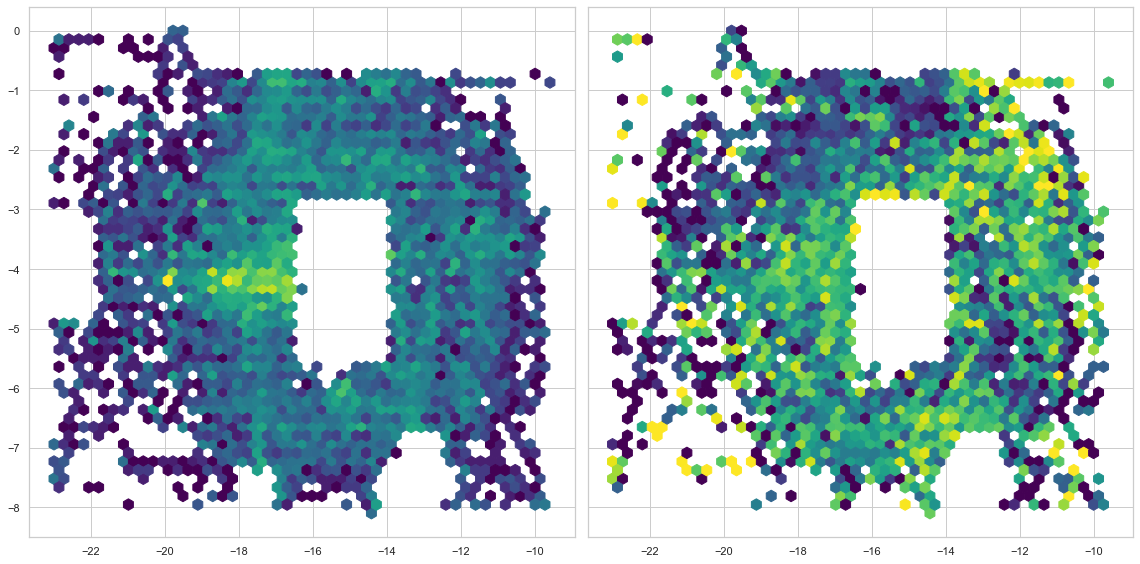

In [38]:
# The first plot shows the original frequency of where users tend to stand 
# The new second plot shows where users tend to turn (where their eyes are most unaligned with their heads - where they are more likely to turn/not fixate on an object)
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)

pc = ax[0].hexbin(df_focus_head['C_x'], df_focus_head['C_z'], cmap='viridis', mincnt=1, gridsize=50, bins='log')
pc = ax[1].hexbin(df_focus_head['C_x'], df_focus_head['C_z'], C=df_focus_head["binned_in_line_abs"], cmap='viridis', mincnt=1, gridsize=50, bins='log')
fig.tight_layout()


# POG Movement Analysis

In [34]:
# Importing the fixation data
df_fixation = pd.DataFrame()

for csv in glob.glob('./Re_Plus10previous/*.csv'):
    id = ""
    for m in os.path.splitext(os.path.basename(csv))[0]:
        if m.isdigit():
            id = id + m
    new = pd.DataFrame(pd.read_csv(csv, header=None, skiprows=[0])).iloc[:, :-2]
    new['id'] = id
    df_fixation = pd.concat([df_fixation, new])

# Merging the fixation data and the previous df (to only include the shared rows)
columns = list(pd.read_csv('./Re_Plus10previous/1_train_Re.csv', header=0).columns[:-2]) + ['id']
df_fixation.columns = columns
df_fixation.set_index(['id', 'num'], inplace=True)

df_merged = pd.merge(df_focus_head, df_fixation, left_index=True, right_index=True)
df_merged = df_merged[df_merged["L_x"].notna()]

# More data cleaning
# Drop repeated consecutive times (drop first)
#df_fixation = df_fixation.loc[df['time'].shift() != df['time']]

# Drop row at time 0.000 (index 1) as these are not accurate
#df_fixation = df_fixation.loc[df_fixation['time'] != 0.000]

# Keep only confident eye tracking coords for eye path analysis
#df_eye2 = df_merged[df_merged['confidence'] > 0.6]

# Remove some outlier PoG eye measurments (some are outside of the room coordinates)
#df_eye2 = df_eye2[(df_eye2['L_x'] >= -23.9) & (df_eye2['L_x'] <= -9)]
#df_eye2 = df_eye2[(df_eye2['L_y'] >= 0) & (df_eye2['L_y'] <= 3.7)]
#df_eye2 = df_eye2[(df_eye2['L_z'] >= -9.7) & (df_eye2['L_z'] <= 0.4)]

#df_merged.drop(['L_x', 'L_y', 'L_z'], axis=1, inplace=True)
#df_eye2.drop(['time', 'C_x', 'C_y', 'C_z', 'confidence'], axis=1, inplace=True)

#df_merged = pd.merge(df.reset_index(), df_eye.reset_index(), how='left', on=['id', 'index']).set_index(keys=['id', 'index'])

               time   L_x  L_y  L_z   C_x  C_y  C_z  F_x  F_y  F_z  ...  \
id num                                                              ...   
10 1      42690.870 -15.5  2.0 -4.2 -19.8  2.0 -4.2  1.0  0.1  0.0  ...   
   110    42690.910 -15.5  2.0 -4.3 -19.8  2.0 -4.2  1.0  0.1  0.0  ...   
   189    42690.970 -15.5  1.7 -4.2 -19.8  1.7 -4.2  1.0  0.1  0.0  ...   
   200    42691.040 -15.5  1.7 -4.3 -19.8  1.7 -4.2  1.0  0.1  0.0  ...   
   207    42691.140 -15.5  1.7 -4.2 -19.8  1.7 -4.2  1.0  0.1  0.0  ...   
...             ...   ...  ...  ...   ...  ...  ...  ...  ...  ...  ...   
9  15971   7640.960  -9.3  1.2 -3.5 -16.9  1.6 -4.2  1.0 -0.1  0.0  ...   
   15978   7641.028  -9.3  1.2 -3.4 -16.9  1.6 -4.2  1.0 -0.1  0.0  ...   
   15986   7641.064  -9.3  1.2 -3.2 -17.0  1.6 -4.1  1.0 -0.1  0.0  ...   
   15989   7641.097  -9.3  1.2 -3.2 -17.0  1.6 -4.1  1.0 -0.1  0.0  ...   
   15992   7641.132  -9.3  1.2 -3.1 -17.1  1.6 -4.0  1.0 -0.1  0.0  ...   

          circle_3d_cent

KeyboardInterrupt: 

In [ ]:
# Do users tend to walk towards where they are looking?
# Similar to previous, but analysing movement (C) instead of head position (F)

# L_x, L_y and L_z is where the users are looking
# Data processing has been done previously e.g. all condifence levels are above 60%
# No need for L_y since we do not have C_y
# C_x, C_y is where they are and path_df is where they are walking
# Data processing has been done previously e.g. C_y has been removed as it should be fixed in place

# Keeping only the rows where C differs
df_merged["movement_change_x"] = df_merged["C_x"].shift(-1) - df_merged["C_x"]
df_merged["movement_change_z"] = df_merged["C_z"].shift(-1) - df_merged["C_z"]

df_merged["C_x_shift"] = df_merged["C_x"].shift(-1)
df_merged["C_z_shift"] = df_merged["C_z"].shift(-1)

df_merged = df_merged[df_merged["movement_change_x"] != 0]
df_merged = df_merged[df_merged["movement_change_z"] != 0]

# Calculate the direction of movement angle 
df_merged["movement_angle"] = df_merged.apply(lambda y: calculate_angle_focus(y["C_x"], y["C_z"], y["C_x_shift"], y["C_z_shift"]), axis=1)

# See how far off C and F are and then plot
df_merged["movement_in_line_abs"] = df_merged.apply(lambda a: angle_diff_abs(a["movement_angle"], a["focus_angle"]), axis=1)

df_merged["binned_movement_in_line_abs"] = np.searchsorted(bins_2, df_fixation["in_line"].values)
df_merged.hist(column="binned_movement_in_line_abs");

In [ ]:
# A plot showing the points where people do not tend to walk towards where they are looking
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)

pc = ax[0].hexbin(df_merged['C_x'], df_merged['C_z'], C=df_merged["binned_movement_in_line_abs"], cmap='viridis', mincnt=1, gridsize=50, bins='log')
fig.tight_layout()

# Vestibulo-Ocular Reflex

In [ ]:
# Direction of head movement vs eye movement 
# (Plotted head velocity vs gaze velocity)

# Is the vestibulo-ocular reflex observed? 
# E.g. when fixating, if you turn your head then your eyes move in the opposite direction

# Must be the turning focus points data only - identify pairs of rows where head angle is different and find the differences in angles
# Remove values with 0 as the change

# Find the change in focus angles and the change in head angles (eg if we turn our head left, our eyes should move right when fixating)
df_merged["focus_change"] = df_merged["focus_angle"].shift(-1) - df_merged["focus_angle"]
df_merged["head_change"] = -(df_merged["head_angle"].shift(-1) - df_merged["head_angle"])

#df_focus_head.plot(x=df_focus_head["focus_change"], y=df_focus_head["head_change"], style='o')

# Clean the data
df_merged = df_merged[df_merged["head_change"] != 0]
df_merged.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
df_merged.dropna(inplace=True)

# Plot to see whether a rough straight line is seen
x = np.array(df_merged["focus_change"])
y = np.array(df_merged["head_change"])
a, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, a*x+b)   
plt.show()
